In [ ]:
!pip install torch onnx onnxruntime scikit-learn pandas numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving creditcard.csv to creditcard.csv


In [ ]:
import pandas as pd

df = pd.read_csv("creditcard.csv")


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
import torch
import torch.nn as nn

class FraudMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout=0.0):
        super().__init__()
        layers = []

        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = h

        layers.append(nn.Linear(prev_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [ ]:
from tqdm.notebook import trange
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import pandas as pd

def train_model(model, lr, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    loader = DataLoader(dataset, batch_size=256, shuffle=True)

    model.train()
    epoch_losses = []

    for epoch in trange(epochs, desc="Training Epochs", leave=True):
        epoch_loss = 0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb).squeeze()
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)

        avg_loss = epoch_loss / len(loader.dataset)
        epoch_losses.append(avg_loss)

    # Display after training
    df_losses = pd.DataFrame({"epoch": range(1, epochs+1), "loss": epoch_losses})
    display(df_losses)
    return model, df_losses



In [ ]:
from sklearn.metrics import roc_auc_score

def evaluate(model):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
        probs = torch.sigmoid(logits).numpy()
    return roc_auc_score(y_test, probs)


In [ ]:
model = FraudMLP(input_dim=X_train.shape[1], hidden_dims=[32], dropout=0.0)
model, losses = train_model(model, lr=1e-3)
score = evaluate(model)




Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

,epoch,loss
0,1,0.064279
1,2,0.004415
2,3,0.003410
3,4,0.003024
4,5,0.002827
5,6,0.002650
6,7,0.002503
7,8,0.002370
8,9,0.002288
9,10,0.002204


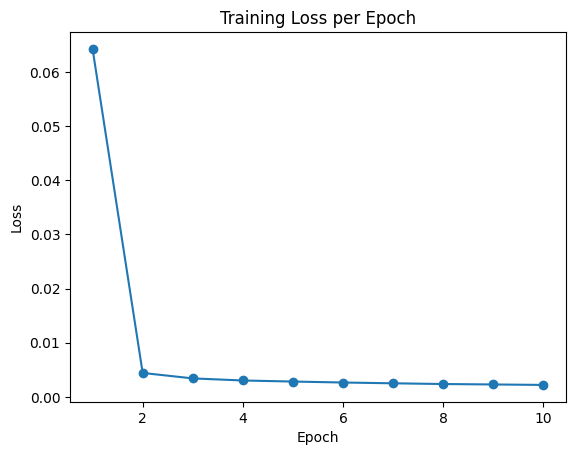

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses["epoch"], losses["loss"], marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.show()


In [ ]:
results = []
results.append({
    "layers": [64, 32],
    "dropout": 0.3,
    "lr": 1e-3,
    "roc_auc": score
})


In [ ]:
from sklearn.metrics import roc_auc_score
import torch

model.eval()  # very important!

with torch.no_grad():
    logits = model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
    probs = torch.sigmoid(logits).numpy()

roc_auc = roc_auc_score(y_test, probs)
print("Neural Network ROC-AUC:", roc_auc)


Neural Network ROC-AUC: 0.9790167086812215


In [ ]:
results.append({
    "layers": [64,32],
    "dropout": 0.3,
    "lr": 1e-3,
    "roc_auc": roc_auc
})


In [ ]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("roc_auc", ascending=False)
df_results


,layers,dropout,lr,roc_auc
0,"[64, 32]",0.3,0.001,0.979017
1,"[64, 32]",0.3,0.001,0.979017


In [ ]:
# Save CSV
df_results.to_csv("nn_experiments.csv", index=False)

# Download locally from Colab
from google.colab import files
files.download("nn_experiments.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install onnx onnxruntime onnxscript


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 13.9 MB/s eta 0:00:00


In [ ]:
import torch

dummy_input = torch.randn(1, X_train.shape[1])
torch.onnx.export(
    model,
    dummy_input,
    "fraud_mlp.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=11
)
from google.colab import files
files.download("fraud_mlp.onnx")  # download for GitHub


W0105 18:04:07.374000 849 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `FraudMLP([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `FraudMLP([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/BaseConverter.h:68: adapter_lookup: Assertion `false`

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>